# BatchTNMC for 2D Ising model

In this example, we demonstrate how to use `BatchTNMC` to sample configurations of a 2D Ising model and estimate its partition function.

In [1]:
from sampler import SamplerIsing
from create_instances import create_rbim
from create_cache import create_cache_ising
from utils import compute_energy, metropolis

import torch
import math

First, we create an Ising model instance:

In [2]:
L = 32  # linear system size
p = 0  # p=0 for ferromagnetic Ising model
seed = 0
G = create_rbim(L, p, seed=seed)

Successfully created instance and saved to ./instances/L32_p0.000000_seed0.pt


Next, we create a cache for the sampling, here we use bond dimension `chi=8`, and this will create a cache file in the `cache` folder:

In [3]:
beta = 0.44  # near critical temperature
chi = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
create_cache_ising(L, chi, beta, p, seed=seed, device=device)

Building MPS cache: 100%|██████████| 31/31 [00:04<00:00,  6.53it/s]

Successfully created MPS cache and saved to ./cache/L32_chi8_beta0.440000_p0.000000_seed0/


Ok, then we can compute the energies of the sampled configurations and estimate the partition function:

$$
Z = \sum_{\{s\}} e^{-\beta E(s)} \approx \frac{1}{N} \sum_{i=1}^{N} \frac{e^{-\beta E(s_i)}}{q(s_i)}
$$

The exact solution given by kacward method is 939.9836361516848.

Now we can draw samples using the `SamplerIsing` class:

In [4]:
# draw samples
bs = 1000  # batch size
sampler = SamplerIsing(L, chi, beta, p, seed=seed, device=device)
cfgs, log_probs = sampler.sample(bs=bs)

Sampling row: 100%|██████████| 32/32 [00:02<00:00, 14.30it/s]


In [5]:
cfgs, log_probs = cfgs.cpu(), log_probs.cpu()
energies = compute_energy(2 * cfgs - 1, sampler.J_mat.cpu())
acc_rate, acc_list = metropolis(log_probs.cpu(), energies.cpu(), beta)
print(f"Metropolis acceptance rate: {acc_rate:.4f}")
logw = -beta * energies - log_probs
logZ_hat = torch.logsumexp(logw, dim=0) - math.log(bs)
print(f"Estimated logZ: {logZ_hat.item()}")

Metropolis acceptance rate: 0.9970
Estimated logZ: 939.98388671875


Finally, we study the performance of `BatchTNMC` with different bond dimensions:

In [6]:
def test(chi):
    create_cache_ising(L, chi, beta, p, seed=seed, device=device)
    sampler = SamplerIsing(L, chi, beta, p, seed=seed, device=device)
    cfgs, log_probs = sampler.sample(bs=bs)
    cfgs, log_probs = cfgs.cpu(), log_probs.cpu()
    energies = compute_energy(2 * cfgs - 1, sampler.J_mat.cpu())
    acc_rate, acc_list = metropolis(log_probs.cpu(), energies.cpu(), beta)
    logw = -beta * energies - log_probs
    logZ_hat = torch.logsumexp(logw, dim=0) - math.log(bs)
    return acc_rate, logZ_hat.item()

In [7]:
logZ_exact = logZ_exact = 939.9836361516848
acc_list = []
err_list = []
for chi in [1, 2, 4, 8, 16]:
    print(f"chi={chi}")
    acc_rate, logZ_hat = test(chi)
    acc_list.append(acc_rate)
    err_list.append(abs(logZ_hat - logZ_exact) / abs(logZ_exact))

chi=1


Building MPS cache:   0%|          | 0/31 [00:00<?, ?it/s]

Building MPS cache: 100%|██████████| 31/31 [00:03<00:00, 10.01it/s]


Successfully created MPS cache and saved to ./cache/L32_chi1_beta0.440000_p0.000000_seed0/


Sampling row: 100%|██████████| 32/32 [00:02<00:00, 15.09it/s]


chi=2


Building MPS cache: 100%|██████████| 31/31 [00:03<00:00,  9.24it/s]


Successfully created MPS cache and saved to ./cache/L32_chi2_beta0.440000_p0.000000_seed0/


Sampling row: 100%|██████████| 32/32 [00:02<00:00, 15.77it/s]


chi=4


Building MPS cache: 100%|██████████| 31/31 [00:02<00:00, 10.41it/s]


Successfully created MPS cache and saved to ./cache/L32_chi4_beta0.440000_p0.000000_seed0/


Sampling row: 100%|██████████| 32/32 [00:01<00:00, 16.68it/s]


chi=8


Building MPS cache: 100%|██████████| 31/31 [00:04<00:00,  6.25it/s]


Successfully created MPS cache and saved to ./cache/L32_chi8_beta0.440000_p0.000000_seed0/


Sampling row: 100%|██████████| 32/32 [00:01<00:00, 16.61it/s]


chi=16


Building MPS cache: 100%|██████████| 31/31 [00:10<00:00,  3.05it/s]


Successfully created MPS cache and saved to ./cache/L32_chi16_beta0.440000_p0.000000_seed0/


Sampling row: 100%|██████████| 32/32 [00:01<00:00, 16.63it/s]


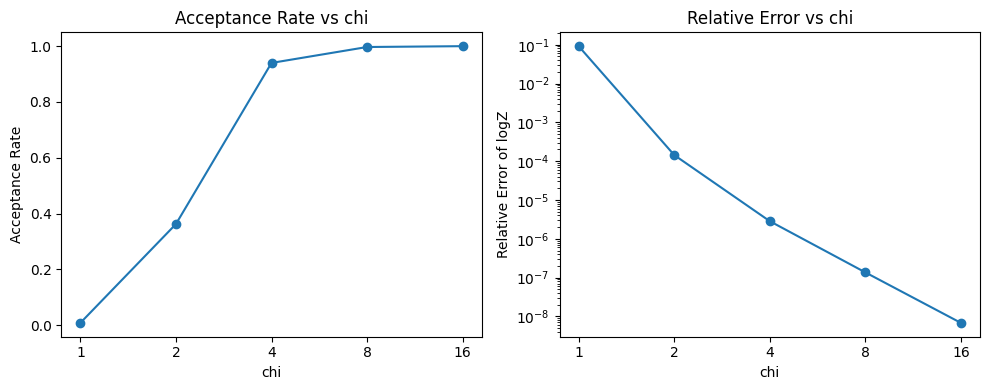

In [8]:
import matplotlib.pyplot as plt

chi_values = [1, 2, 4, 8, 16]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot acc_list
axes[0].plot(acc_list, marker="o")
axes[0].set_xlabel("chi")
axes[0].set_ylabel("Acceptance Rate")
axes[0].set_title("Acceptance Rate vs chi")
axes[0].set_xticks(range(len(chi_values)))
axes[0].set_xticklabels(chi_values)

# Plot err_list
axes[1].plot(err_list, marker="o")
axes[1].set_xlabel("chi")
axes[1].set_ylabel("Relative Error of logZ")
axes[1].set_title("Relative Error vs chi")
axes[1].set_xticks(range(len(chi_values)))
axes[1].set_xticklabels(chi_values)
axes[1].set_yscale("log")

plt.tight_layout()
plt.show()